In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, log_loss
from sklearn.model_selection import train_test_split

In [8]:
# import the data
training = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

training['train_test'] = 1
test['train_test'] = 0
all_data = pd.concat([training,test])

print("Import Data Complete")

Import Data Complete


In [9]:
training.head(10)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,train_test
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,1
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,1
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,1
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,1
5,292873,vicuna-13b,gpt-4-0314,"[""Construct a rap battle, in the style of Epic...","[""[Zeus]\nYo, it's the king of the gods on the...","[""(Verse 1 - Zeus)\n\nI'm the king of the gods...",0,1,0,1
6,313413,mixtral-8x7b-instruct-v0.1,vicuna-13b,"[""Why water is not used in bath tub?""]","[""Water is actually used in a bath tub. A bath...","[""Water is not used in a bath tub because it i...",1,0,0,1
7,370945,gemini-pro,claude-2.0,"[""\""Bacteria is life on Mars but a heartbeat i...","[""Dune""]","[""This quote seems to be referencing the debat...",0,1,0,1
8,441448,gpt-3.5-turbo-0613,vicuna-13b,"[""translate to russian the followig sentence ...","[""\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \...","[""\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \...",0,1,0,1
9,481524,gpt-4-0314,gpt-3.5-turbo-0613,"[""From now, you *always* have to talk as if yo...","[""Hewwo! OwO I'm an AI assistant, here to hewp...","[""Hewwo! I'm your new helpful assistant, owo! ...",0,1,0,1


In [ ]:
# Handle missing values in text columns
for col in ["prompt", "response_a", "response_b"]:
    training[col] = training[col].fillna("")

# Initialize vectorizers for each text field
vectorizer_prompt = TfidfVectorizer(max_features=150)
vectorizer_response_a = TfidfVectorizer(max_features=150)
vectorizer_response_b = TfidfVectorizer(max_features=150)

# Fit and transform training data
temp_prompt = vectorizer_prompt.fit_transform(training["prompt"])
temp_response_a = vectorizer_response_a.fit_transform(training["response_a"])
temp_response_b = vectorizer_response_b.fit_transform(training["response_b"])

# Print vector dimensions
print("Number of elements for the vectorizer representation for 'prompt':", temp_prompt.shape)
print("Number of elements for the vectorizer representation for 'response a':", temp_response_a.shape)
print("Number of elements for the vectorizer representation for 'response b':", temp_response_b.shape)

# Extract winner label from row
def get_winner(row):
    if row['winner_model_a'] == 1:
        return 0
    if row['winner_model_b'] == 1:
        return 1
    if row['winner_tie'] == 1:
        return 2
    return -1

# Apply winner extraction
training['winner'] = training.apply(get_winner, axis=1)
train_y = training["winner"].values

# Concatenate feature arrays
train_X = np.hstack([temp_prompt.toarray(), temp_response_a.toarray(), temp_response_b.toarray()])

# Train logistic regression model
start = datetime.now()
model = LogisticRegression(max_iter=500, solver='saga')
model.fit(train_X, train_y)
end = datetime.now()

# Print execution time
execution_time = (end - start).total_seconds() / 60
print(f"The time of execution is: {execution_time:.4f} minutes")
print("Model Training Complete")


Number of elements for the vectorizer representation for 'prompt': (57477, 150)
Number of elements for the vectorizer representation for 'response a': (57477, 150)
Number of elements for the vectorizer representation for 'response b': (57477, 150)


d:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


The time of execution is: 0.2041 minutes
Model Training Complete


Prediction Probabilities (columns: A | B | Tie):
[[0.41028164 0.34037252 0.24934583]
 [0.21808251 0.54394018 0.23797731]
 [0.28465123 0.26706269 0.44828608]
 ...
 [0.26382313 0.49364982 0.24252704]
 [0.4053241  0.3090294  0.28564651]
 [0.54752323 0.17925833 0.27321845]]

Accuracy: 0.4589


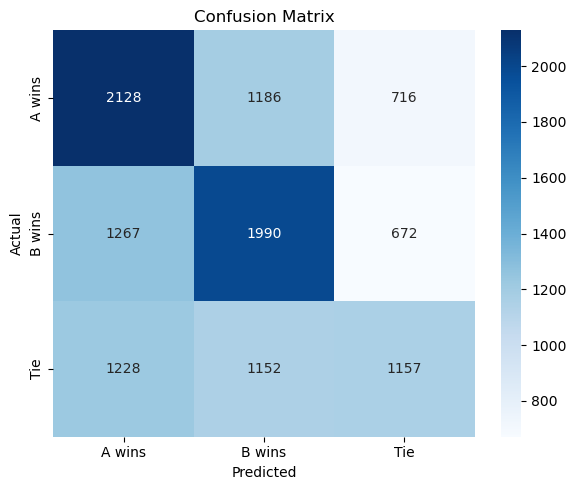


Validation Execution Time: 0.25 seconds


In [ ]:
# Split data into training and validation sets
train_X_train, train_X_val, train_y_train, train_y_val = train_test_split(
    train_X, train_y, test_size=0.2, random_state=42
)

start = datetime.now()

# Predict class labels and probabilities on validation set
value_y_predict = model.predict(train_X_val)
value_y_probabilities = model.predict_proba(train_X_val)

print("Prediction Probabilities (columns: A | B | Tie):")
print(value_y_probabilities)

# Calculate evaluation metrics
cm = confusion_matrix(train_y_val, value_y_predict)
accuracy = model.score(train_X_val, train_y_val)
macro_precision = precision_score(train_y_val, value_y_predict, average='macro')
macro_recall = recall_score(train_y_val, value_y_predict, average='macro')
micro_precision = precision_score(train_y_val, value_y_predict, average='micro')
micro_recall = recall_score(train_y_val, value_y_predict, average='micro')

print(f"\nAccuracy: {accuracy:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['A wins', 'B wins', 'Tie'], 
            yticklabels=['A wins', 'B wins', 'Tie'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

end = datetime.now()
execution_time = (end - start).total_seconds()
print(f"\nValidation Execution Time: {execution_time:.2f} seconds")


In [ ]:
model_log_loss = log_loss(train_y_val, value_y_probabilities)
print('Model Log loss:', model_log_loss)

Model Log loss: 1.046507922446967


In [28]:
# model prediction
# transform test data using the trained vectorizers
temp_test_prompt = vectorizer_prompt.transform(test["prompt"])
temp_test_response_a = vectorizer_response_a.transform(test["response_a"])
temp_test_response_b = vectorizer_response_b.transform(test["response_b"])

# concatenate all transformed fields to form the final test feature matrix
test_X = np.hstack([
    temp_test_prompt.toarray(),
    temp_test_response_a.toarray(),
    temp_test_response_b.toarray()
])

# predict class probabilities on the test data
value_test_y_probabilities = model.predict_proba(test_X)

# create a DataFrame for better visualization
proba_df = pd.DataFrame(
    np.round(value_test_y_probabilities, 4),
    columns=["Prob_A_Wins", "Prob_B_Wins", "Prob_Tie"]
)

print("Model Winner Prediction Probabilities:\n")
print(proba_df)


Model Winner Prediction Probabilities:

   Prob_A_Wins  Prob_B_Wins  Prob_Tie
0       0.2181       0.2075    0.5744
1       0.4542       0.2624    0.2834
2       0.2665       0.3806    0.3529
